# Compute the Stopping Distance for a Projectile
Compute the stopping distance of a projectile using the multi-velocity machine learning model.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
from scipy.integrate import solve_ivp, RK45
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

Using TensorFlow backend.


Constants

In [2]:
mass_proj = 1837  # Mass of hydrogen in a.u.
mean_stopping = 0.2  # Mean stopping power (used to estimate distance)

## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [3]:
model = keras.models.load_model(os.path.join('..', 'model.h5'))

In [4]:
with open(os.path.join('..', 'featurizer.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)

In [5]:
start_frame = pkl.load(open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb'))

Get the channel data at a single velocity

In [6]:
channel_data = pd.read_pickle(os.path.join('..', '..', 'single-velocity', 'data', 'channel_data.pkl.gz')).query('average_range')

Get the minimum velocity of all training data

In [7]:
min_velocity = pd.read_pickle(os.path.join('..', '..', 'training_data.pkl.gz'))['velocity_mag'].mean()

## Make the Trajectory Integration Tool
This will black box the annoying parts of computing the force given position and velocity magnitude

In [8]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

In [9]:
f = traj_int.create_force_calculator_given_displacement([0, 0.75, 0.75], [1, 0, 0])

Compare the predictions to the ML model run on the channel data

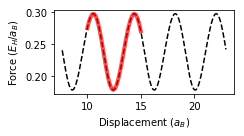

In [10]:
fig, ax = plt.subplots()

X = np.linspace(10, 15, 32)

ax.plot(channel_data['displacement'], 
        model.predict(channel_data[featurizers.feature_labels()]),
        'k--')
ax.plot(X, [f(x, channel_data['velocity_mag'].mean()) for x in X], label='Force Calculator',
       alpha=0.7, color='r', lw=4)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H / a_B$)')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: The predictions of the trajectory integrator (red) do agree with running the model on the training set. So, my implementation of the force function is correct

## Estimate Stopping Distance Along Channel
Use an ODE solver to get the stopping distance along a channel

In [11]:
def make_ode_function(start_point, start_traj):
    """Make the function used to run the ODE
    
    Args:
        start_point ([float]*3): Starting point of the run
        start_traj ([float]): Staring direction
    """
    
    # Make the force calculator
    force_calc = traj_int.create_force_calculator_given_displacement(start_point, start_traj)
    
    def output(t, y):
        # Get the velocity and displacement
        v, x = y
        
        # Compute the force
        f = force_calc(x, v)
        return [-f / mass_proj, v]
    return output

Estimate stopping distance (TODO: Double-check units!)

In [12]:
def estimate_stopping(start_velocity, stop_velocity=0.3, average_s=mean_stopping, mass_proj=mass_proj):
    """Estimate the stopping time given projectile initial conditions
    
    All units are expected to be atomic units
    
    Args:
        start_velocity (float): Starting velocity
        stop_velocity (float): Stopping velocity
        average_s (float): Average stopping force
        mass_proj (float): Mass of projectile
    Returns:
        (float) Estimated stopping distance
    """
    
    a = average_s / mass_proj
    return (start_velocity - stop_velocity) / a
print('Expected stopping time for v=1.0: {:.2f}'.format(estimate_stopping(1)))

Expected stopping time for v=1.0: 6429.50


Show how the position changes over time

In [13]:
times = np.linspace(0, estimate_stopping(4) * 8, 256)

In [14]:
%%time
res = solve_ivp(make_ode_function([0, 0.75, 0.75], [1, 0, 0]), (0, times.max()), [4, 0], t_eval=times)

CPU times: user 1min 19s, sys: 472 ms, total: 1min 20s
Wall time: 2min 36s


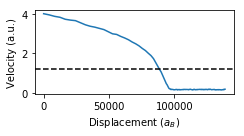

In [15]:
fig, ax = plt.subplots()

ax.plot(res.y[1, :], res.y[0, :])
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')
ax.set_xlim(ax.get_xlim())

ax.plot(ax.get_xlim(), [min_velocity]*2, 'k--')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: The curve has a reasonable shape. More or less linear at the beginning, and then quickly dropping as the particle slows down and the stopping power increases. The long flat tail is an artifact of the stopping power going to zero at non-zero velocity. The black dashed line shows the minimum velocity present in the training set. You'll note that the artifact is outside of our training range, suggesting we would need more training data at this velocity than what we currently have

## Check that the tool works for off-channel trajectories
These will have sharper changes in force than the on-channel directories. In this version, we also do not attempt to determine a stopping distance

In [16]:
%%time
state = [4, 0]
i = 0
states = []
rk = RK45(make_ode_function([0, 0.75, 0.75], [4, 2, 1]), 0, [4, 0], 1e8, max_step=2)
while rk.y[0] > 0.3:
    rk.step()
    i += 1
    states.append(rk.y)
    if i % 10 == 0:
        print('\rStep: {} - Velocity: {} - Position: {}'.format(i, rk.y[0], rk.y[1]), end="")
states = pd.DataFrame(dict(zip(['v', 'x'], np.transpose(states))))

Step: 18710 - Velocity: 0.3024424781362874 - Position: 79719.19454763478CPU times: user 20min 30s, sys: 10.1 s, total: 20min 40s
Wall time: 25min 31s


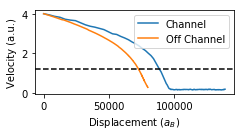

In [17]:
fig, ax = plt.subplots()

ax.plot(res.y[1, :], res.y[0, :], label='Channel')
ax.plot(states['x'], states['v'], label='Off Channel')

ax.legend()

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')
ax.set_xlim(ax.get_xlim())

ax.plot(ax.get_xlim(), [min_velocity]*2, 'k--')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: The off-channel projectile does stop in a shorter distance.

**TODO**: Write an abstract class for holding all of these functions, assess the effect of step size, parallelize